<a href="https://colab.research.google.com/github/FrancescaTorazzi/jellyfish_classification-/blob/main/Copia_di_individui__2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [ ]:
from d2l import torch as d2l

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Dataset Reference**

The dataset used in this project is the **"Natural Images"** dataset, available on **Kaggle**.
It contains **6,899 images** belonging to **8 distinct categories**: airplane, car, cat, dog, flower, fruit, motorbike, and person.

- **Title:** Natural Images
- **Source:** Kaggle
- **Link:** [Natural Images Dataset on Kaggle](https://www.kaggle.com/datasets/prasunroy/natural-images)

This dataset is openly accessible and widely used for image classification tasks, providing a balanced distribution of images across the categories.



**Image Classification with AlexNet: A Multi-Category Approach**

This project explores the automatic classification of various image categories by primarily utilizing a customized AlexNet model.
The goal is to accurately classify images into one of eight distinct classes: flowers, motorbike, fruit, cat, person, dog, car, and airplane.
To evaluate the performance, the model's accuracy and loss are measured on both training and validation sets.

The dataset consists of a balanced collection of approximately 7,000 to 8,000 images, evenly distributed among the eight categories,
with each class containing between 700 and 1,000 images. The original image dimensions vary, but most are under 500 pixels in width and height.

The categories are described as follows:

- **Flowers**: Vibrant and colorful blooms captured from various angles and environments.
- **Motorbike**: Sleek and dynamic motorbikes presented from different viewpoints.
- **Fruit**: Fresh and vivid fruits displaying diverse shapes and colors.
- **Cat**: Domestic and wild cats depicted in both natural and posed scenarios.
- **Person**: Human subjects in various postures and activities.
- **Dog**: A wide range of dog breeds exhibiting unique physical traits.
- **Car**: Automobiles shown from multiple perspectives and angles.
- **Airplane**: Aircraft captured both in flight and on the ground.

By leveraging data augmentation and normalization techniques, the model is trained from scratch to maximize performance and accuracy.


In [5]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/Natural_images.zip"

In [7]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

This code imports a ZIP file from Google Drive and extracts its contents into the `/content/dataset` directory in the Google Colab environment.

In [8]:
import zipfile  # Module to work with ZIP archives
import os       # Module to interact with the operating system

# Define the path to the ZIP file located in Google Drive
zip_path = "/content/drive/MyDrive/Colab Notebooks/Natural_images.zip"

# Define the path where the ZIP file will be extracted
extract_path = "/content/dataset"

# Extracting the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extract all contents to the specified directory

print("File extracted in:", extract_path)  # Confirm successful extraction


File extracted in: /content/dataset


In order to verify that the ZIP file was extracted correctly and to see the structure of the extracted data we printed all the files present in the extraction path.

In [9]:
print(os.listdir(extract_path))

['natural_images', 'data']


**Dataset Description**

In [70]:
import os
dataset_path = "/content/dataset/natural_images"

num_images = 0
for root, _, files in os.walk(dataset_path):
    for image_name in files:
        if image_name.endswith(('.jpg', '.png', '.jpeg')):
            num_images += 1

# Dictionary to store the number of images per category
image_counts = {}

# Scan through the folders in the dataset
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):  # Check if it's a directory
        # Count only files with image extensions
        num_images = sum(1 for file in os.listdir(category_path) if file.endswith(('.jpg', '.png', '.jpeg')))
        image_counts[category] = num_images

# Print the results
print("Number of images per category:")
for category, count in image_counts.items():
    print(f"  {category}: {count} images")

Number of images per category:
  flower: 843 images
  car: 968 images
  person: 986 images
  motorbike: 788 images
  dog: 702 images
  cat: 885 images
  airplane: 727 images
  fruit: 1000 images


- **Total Images**: The dataset consists of 6,899 images.
- **Category Distribution**:
  - Fruit: 1,000 images
  - Person: 986 images
  - Car: 968 images
  - Cat: 885 images
  - Flower: 843 images
  - Motorbike: 788 images
  - Airplane: 727 images
  - Dog: 702 images
- **Dimensions Distribution**:
  - Most images have dimensions below 500 pixels.
  - Aspect ratio is approximately 1:1 for most images.

**Pie chart**

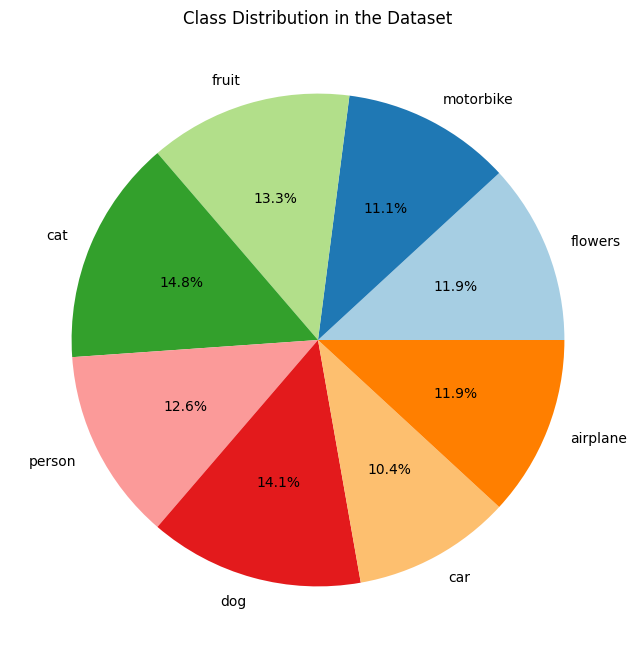

In [ ]:
import matplotlib.pyplot as plt

# Dictionary with the number of images per class (replace with your actual data)
image_counts = {
    'flowers': 800,
    'motorbike': 750,
    'fruit': 900,
    'cat': 1000,
    'person': 850,
    'dog': 950,
    'car': 700,
    'airplane': 800
}

def plot_image_distribution_pie(image_counts):
    """
    Function to generate a pie chart showing the distribution of images per class.
    """
    plt.figure(figsize=(8, 8))  # Set the figure size
    plt.pie(
        image_counts.values(),  # Image counts
        labels=image_counts.keys(),  # Class labels
        autopct='%1.1f%%',  # Display percentage with one decimal
        colors=plt.cm.Paired.colors  # Use a predefined color palette
    )
    plt.title("Class Distribution in the Dataset")  # Set the title
    plt.show()  # Display the chart

# Generate the pie chart
plot_image_distribution_pie(image_counts)


The image above shows a pie chart representing the distribution of images by category within the dataset.
Each slice corresponds to one of the eight classes: flowers, motorbike, fruit, cat, person, dog, car, and airplane.
The chart illustrates that the distribution is relatively balanced, with slight variations among categories.
The most represented category is "cat" with 14.8% of the total images, while the "car" category has the smallest proportion at 10.4%.



**Dimensions and aspect ratios of images**

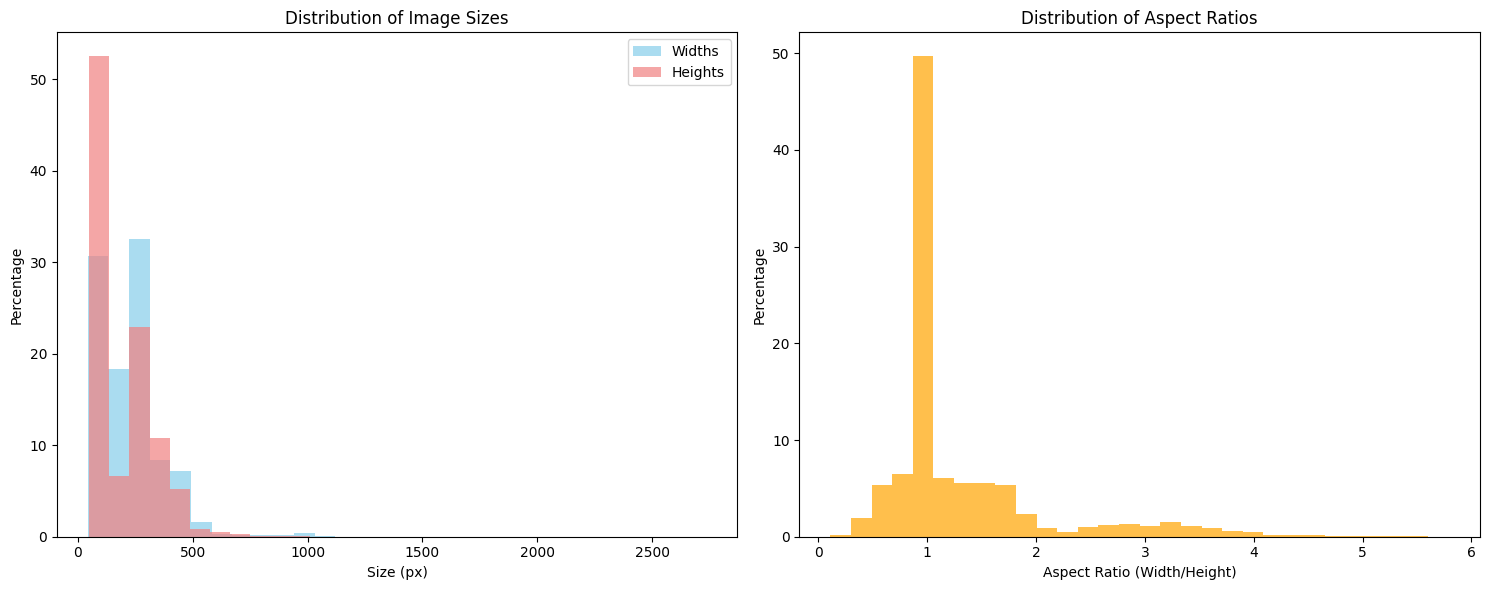

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset path
dataset_path = "/content/dataset/natural_images"

# Extract image dimensions
image_sizes = []

for root, _, files in os.walk(dataset_path):  # Traverse folders and subfolders of dataset_path
    for image_name in files:
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Consider multiple image formats
            image_path = os.path.join(root, image_name)  # Full path to the image
            try:
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                continue  # Skip unreadable images

# Ensure there are images before proceeding
if len(image_sizes) > 0:
    # Analyze widths, heights, and aspect ratios
    widths = [size[0] for size in image_sizes]
    heights = [size[1] for size in image_sizes]
    aspect_ratios = [w / h for w, h in zip(widths, heights)]

    # Distribution of dimensions (width, height)
    width_counts, width_bins = np.histogram(widths, bins=30)
    height_counts, height_bins = np.histogram(heights, bins=30)
    width_percent = (width_counts / len(widths)) * 100
    height_percent = (height_counts / len(heights)) * 100

    # Distribution of aspect ratios
    aspect_counts, aspect_bins = np.histogram(aspect_ratios, bins=30)
    aspect_percent = (aspect_counts / len(aspect_ratios)) * 100

    # Plot distributions
    plt.figure(figsize=(15, 6))

    # Plot 1: Distribution of dimensions
    plt.subplot(1, 2, 1)
    plt.bar(width_bins[:-1], width_percent, width=np.diff(width_bins)[0], alpha=0.7, label='Widths', align='edge', color='skyblue')
    plt.bar(height_bins[:-1], height_percent, width=np.diff(height_bins)[0], alpha=0.7, label='Heights', align='edge', color='lightcoral')
    plt.title('Distribution of Image Sizes')
    plt.xlabel('Size (px)')
    plt.ylabel('Percentage')
    plt.legend()

    # Plot 2: Distribution of aspect ratios
    plt.subplot(1, 2, 2)
    plt.bar(aspect_bins[:-1], aspect_percent, width=np.diff(aspect_bins)[0], alpha=0.7, color='orange')
    plt.title('Distribution of Aspect Ratios')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Percentage')

    plt.tight_layout()
    plt.show()
else:
    print("No images found in the dataset. Please check the dataset path and file formats.")


1.   **Distribution of image size**

It represents the distribution of image widths (Widths, in blue) and heights (Heights, in red) within the dataset.
The x-axis indicates image dimensions in pixels (either width or height), while the y-axis shows the percentage of images with those dimensions.

Observations:


*  Most images have a width and height
between 0 and 500 px, suggesting that the dataset mainly contains small-sized images.


*   There is a sharp decline beyond 500 px, meaning very few images exceed this size.


*   The distributions of widths and heights appear similar, which could indicate that many images are either square or follow a common aspect ratio.


2.   **Distribution of Aspect ratios**

The x-axis represents the width/height ratio of each image.
The y-axis shows the percentage of images with that specific aspect ratio.

Observations:

*   Most images have an aspect ratio close to 1, meaning they are almost square (width ≈ height).

*   Some images have an aspect ratio greater than 1, indicating they are wider than they are tall (landscape orientation).
*   Very few images have aspect ratios above 3 or 4, suggesting that the dataset does not contain many stretched images.

**Random Sample Visualization from Each Category**



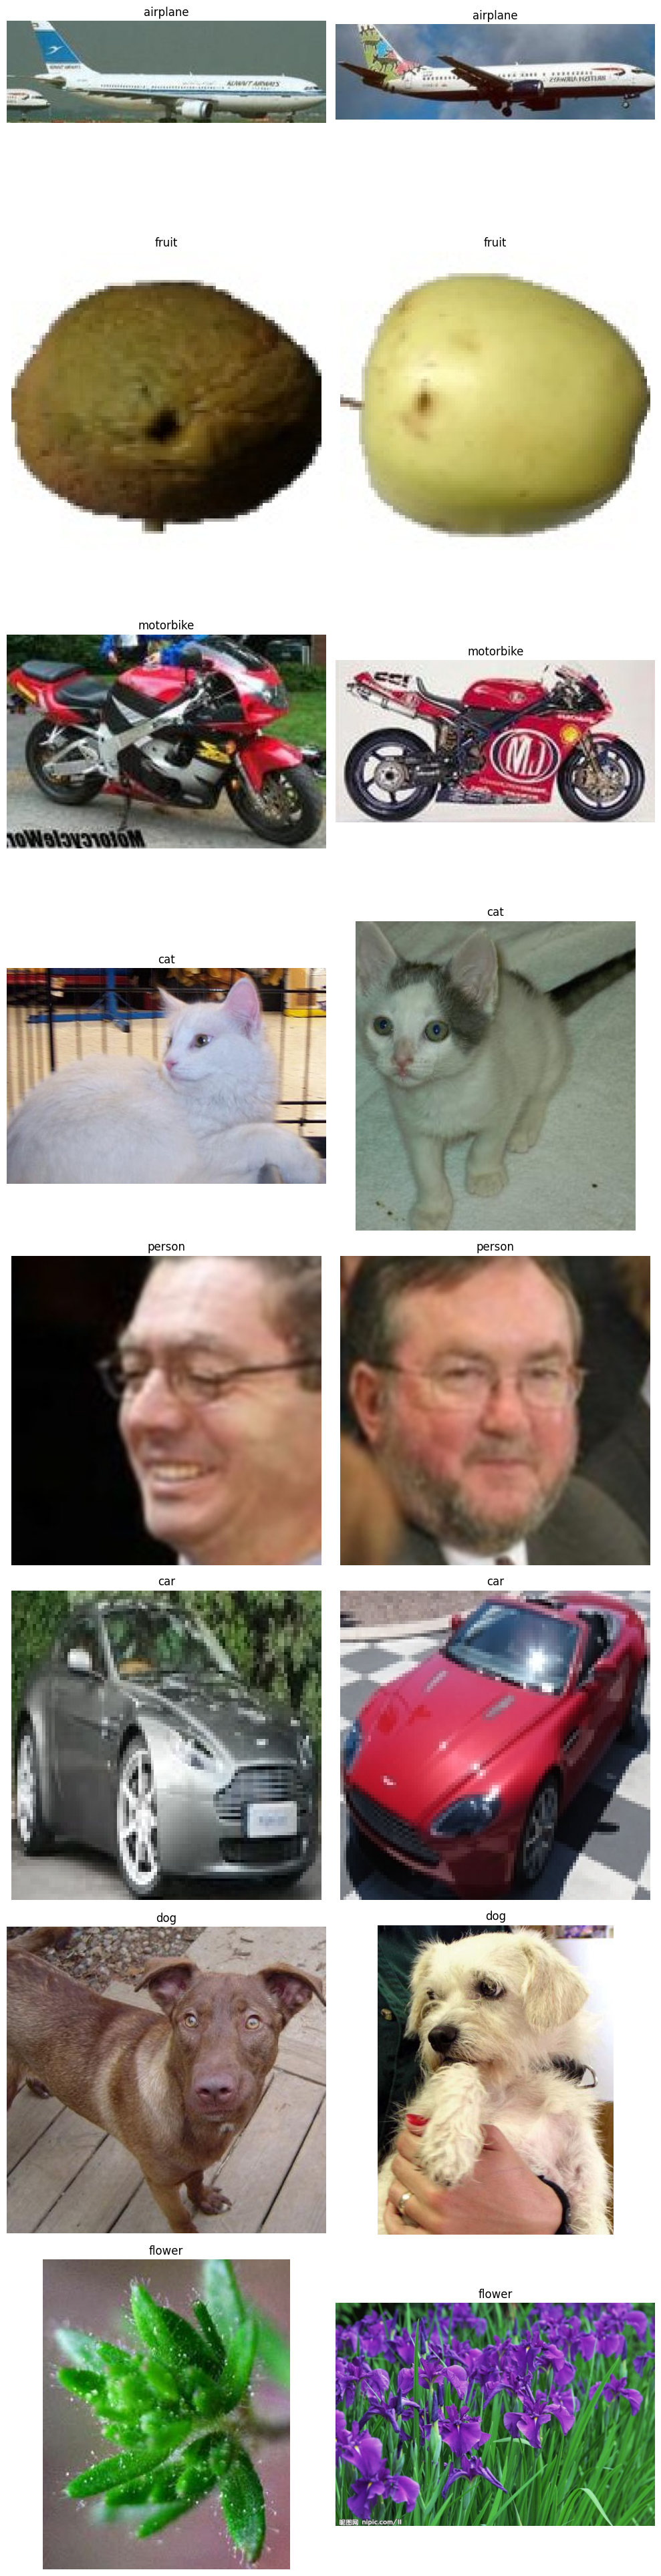

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_sample_images(dataset_path):
    sample_images = {}  # Dictionary to store two sample images per class

    for class_name in os.scandir(dataset_path):
        if class_name.is_dir():  # Check if it's a directory (class folder)
            images = list(os.scandir(class_name.path))  # Get all images in the folder
            if len(images) >= 2:  # Ensure there are at least two images
                sample_images[class_name.name] = [images[0].path, images[1].path]

    num_classes = len(sample_images)
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, 5 * num_classes))  # Create subplots for each class

    for (class_name, img_paths), ax_row in zip(sample_images.items(), axes):
        for img_path, ax in zip(img_paths, ax_row):
            with Image.open(img_path) as img:
                ax.imshow(img)  # Display the image
                ax.set_title(class_name)  # Set the title as the class name
                ax.axis("off")  # Remove axis labels

    plt.tight_layout()
    plt.show()

# Display sample images
show_sample_images(dataset_path)

This code generates a visual overview of the dataset by displaying two sample images from each category. It helps to quickly understand the types of images present and the overall structure of the dataset.

**Check for corrupted images (damaged,incomplete,unreadable)**


In [35]:
from PIL import Image
import os

original_dataset_path = "/content/dataset/natural_images"

corrupted_files = []
for class_name in os.listdir(original_dataset_path):
    class_folder = os.path.join(original_dataset_path, class_name)
    if os.path.isdir(class_folder):
        print(f"Checking class '{class_name}'")
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check if the image is valid
            except Exception as e:
                print(f" Corrupted: {file_path} | Error: {e}")
                corrupted_files.append(file_path)

print(f"\nTotal corrupted files: {len(corrupted_files)}")


Checking class 'flower'
Checking class 'car'
Checking class 'person'
Checking class 'motorbike'
Checking class 'dog'
Checking class 'cat'
Checking class 'airplane'
Checking class 'fruit'

Total corrupted files: 0


In [36]:
for file_path in corrupted_files:
    os.remove(file_path)
    print(f"Removed corrupted file: {file_path}")

**Image Resizing**

The purpose of this code is to resize all images in the dataset to a consistent size of 224x224 pixels.
This step is crucial for preparing the data to be processed by deep learning models that require fixed input dimensions.

The code performs the following tasks:
1. **Directory Setup:**
   - Creates the output directory if it doesn't exist.
   - Maintains the class structure from the original dataset.

2. **Image Processing:**
   - Reads each image from the original dataset.
   - Converts images to RGB format for consistency.
   - Resizes images to 224x224 pixels.

3. **Error Handling:**
   - Detects and skips corrupted or unreadable images.
   - Logs error messages for problematic files.

4. **Progress Tracking:**
   - Uses the tqdm library to display a progress bar for each class being processed.

By ensuring that all images have the same dimensions, the dataset becomes uniform and ready for model training.


In [37]:
from PIL import Image
import os
from tqdm import tqdm

original_dataset_path = "/content/dataset/natural_images"
output_dataset_path = "/content/dataset/resized_images"
target_size = (224, 224)

def resize_images(original_dataset_path, output_dataset_path, target_size):
    """Resize images from original_dataset_path and save them to output_dataset_path."""
    if not os.path.exists(output_dataset_path):
        os.makedirs(output_dataset_path)

    for class_name in os.listdir(original_dataset_path):
        class_folder = os.path.join(original_dataset_path, class_name)
        output_class_folder = os.path.join(output_dataset_path, class_name)

        if os.path.isdir(class_folder):
            if not os.path.exists(output_class_folder):
                os.makedirs(output_class_folder)

            images = os.listdir(class_folder)

            for img_name in tqdm(images, desc=f"Resizing {class_name}", leave=False):
                img_path = os.path.join(class_folder, img_name)
                output_img_path = os.path.join(output_class_folder, os.path.splitext(img_name)[0] + ".jpg")

                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")  # Ensure RGB mode
                        img_resized = img.resize(target_size)  # Remove ANTIALIAS
                        img_resized.save(output_img_path, "JPEG")
                except Exception as e:
                    print(f"Skipping corrupted image: {img_path} | Error: {e}")

# Run resizing
resize_images(original_dataset_path, output_dataset_path, target_size)


**Resized Image Verification**

This script verifies the resized images to ensure consistency and integrity.

- Checks if the output directory exists.
- Iterates through each class folder to count the images.
- Verifies that image dimensions are correctly set to 224x224 pixels.
- Detects and logs corrupted or unreadable images.
- Provides a summary of the total images, incorrect sizes, and corrupted files.

This step guarantees the dataset's consistency before model training.




In [38]:
import os
from PIL import Image

output_dataset_path = "/content/dataset/resized_images"

def check_resized_images(output_path, sample_check=5):
    if not os.path.exists(output_path):
        print(f"The folder '{output_path}' does not exist!")
        return

    total_images = 0
    incorrect_size = 0
    corrupted_images = 0

    print("\n Checking resized dataset...\n")

    for class_name in os.listdir(output_path):
        class_folder = os.path.join(output_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        images = os.listdir(class_folder)
        num_images = len(images)
        total_images += num_images

        print(f" Class '{class_name}': {num_images} images")

        # Sample check: Try to open some images
        for img_name in images[:sample_check]:
            img_path = os.path.join(class_folder, img_name)
            try:
                with Image.open(img_path) as img:
                    # Check if image size is correct
                    if img.size != (224, 224):
                        incorrect_size += 1
                        print(f" Incorrect size: {img_name} ({img.size}), expected (224, 224)")
            except Exception as e:
                corrupted_images += 1
                print(f" Corrupted image: {img_name} | Error: {e}")

    print("\nDataset check completed.")
    print(f"Total images: {total_images}")
    print(f"Incorrect size images: {incorrect_size}")
    print(f"Corrupted images: {corrupted_images}")

# Run the check
check_resized_images(output_dataset_path)



 Checking resized dataset...

 Class 'flower': 843 images
 Class 'car': 968 images
 Class 'person': 986 images
 Class 'motorbike': 788 images
 Class 'dog': 702 images
 Class 'cat': 885 images
 Class 'airplane': 727 images
 Class 'fruit': 1000 images

Dataset check completed.
Total images: 6899
Incorrect size images: 0
Corrupted images: 0


**Dataset Resampling**

Random resampling is performed to reduce the number of images per class to a fixed size (300 by default).
The decision to limit the number of images per class is driven by **time complexity considerations**,
as training the model on the entire dataset would be computationally expensive and time-consuming.

- **Resampling Process:**
  - For each class, 300 images are randomly selected.
  - Selected images are copied to the output folder, maintaining the original class structure.

- **Purpose:**
  - Reduces the computational cost of training by limiting the dataset size.
  - Ensures uniformity across classes while maintaining a representative sample.
  - Allows for faster model training and experimentation without compromising data diversity.


In [39]:
import os
import shutil
import random

def resample_dataset(input_path, output_path, samples_per_class=300):
    """
    Perform random resampling to reduce the number of images per class.
    Copies a fixed number of randomly chosen images from each class.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)

    for class_name in os.listdir(input_path):
        class_folder = os.path.join(input_path, class_name)
        output_class_folder = os.path.join(output_path, class_name)

        if os.path.isdir(class_folder):
            os.makedirs(output_class_folder, exist_ok=True)

            # Get all image files in the class folder
            images = [img for img in os.listdir(class_folder) if img.lower().endswith(('jpg', 'jpeg', 'png'))]

            # Perform random sampling
            sampled_images = random.sample(images, min(samples_per_class, len(images)))

            # Copy the selected images to the new dataset
            for img in sampled_images:
                shutil.copy(os.path.join(class_folder, img), os.path.join(output_class_folder, img))

            print(f"Resampled {len(sampled_images)} images for class '{class_name}'.")

# Paths (relative paths to avoid permission issues)
input_dataset_path = "dataset/resized_images"
output_dataset_path = "dataset/resampled_images"

# Run resampling (e.g., 300 images per class)
resample_dataset(input_dataset_path, output_dataset_path, samples_per_class=300)


Resampled 300 images for class 'flower'.
Resampled 300 images for class 'car'.
Resampled 300 images for class 'person'.
Resampled 300 images for class 'motorbike'.
Resampled 300 images for class 'dog'.
Resampled 300 images for class 'cat'.
Resampled 300 images for class 'airplane'.
Resampled 300 images for class 'fruit'.


In [40]:
dataset_path = "/content/dataset/resampled_images"

**Dataset Loading and Preprocessing**

In this part has been done the loading, preprocessing, and augmentation of the image dataset, as well as the creation of DataLoaders for efficient training, validation, and testing.

1. **Mean and Standard Deviation Calculation:**
   - Calculates the mean and standard deviation of RGB channels using the training set.
   - This helps normalize the pixel values, centering them around zero for better model convergence.

2. **Data Augmentation:**
   - Applied only to the training set to improve model generalization.
   - Techniques include horizontal flipping, rotation, cropping, color jittering, and Gaussian blur.

3. **Dataset Splitting:**
   - Divides the dataset into training, validation, and testing sets.
   - Ensures reproducibility by setting fixed random seeds.

4. **DataLoader Configuration:**
   - Uses DataLoader to efficiently load data in batches.
   - Leverages multiple CPU workers for faster data retrieval.



In [72]:
import os
from torchvision import datasets, transforms
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

# Calculate the mean and standard deviation of the training set
def calculate_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = len(dataset)

    for img, _ in tqdm(dataset):
        mean += img.mean(dim=[1, 2])
        std += img.std(dim=[1, 2])

    mean /= total_images
    std /= total_images
    return mean, std

# Get the optimal number of workers for DataLoader
def get_dataloader_workers():
    return os.cpu_count()

# Load the dataset and create DataLoaders
def data_loader(dataset_path, batch_size, height, width, augmentation=False, train_perc=0.7, val_perc=0.2, seed=123):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Temporary transform to calculate mean and standard deviation
    temp_transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor()
    ])
    temp_dataset = datasets.ImageFolder(root=dataset_path, transform=temp_transform)

    # Calculate mean and standard deviation from the training set
    mean, std = calculate_mean_std(temp_dataset)
    print(f"Calculated Mean: {mean.tolist()}")
    print(f"Calculated Std: {std.tolist()}")

    # Base transformation with normalization
    base_transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Data augmentation transformations (applied only to the training set)
    augmentation_transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomResizedCrop(size=height, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Load the complete dataset with base transformation
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=base_transform)

    # Split the dataset into training, validation, and testing sets
    dataset_size = len(full_dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Apply augmentation only to the training set if specified
    if augmentation:
        train_dataset.dataset.transform = augmentation_transform

    # Create DataLoaders for training, validation, and testing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return full_dataset, train_loader, val_loader, test_loader, mean, std

# Parameters for loading the dataset
dataset_path = "/content/dataset/resampled_images"
batch_size = 64
height, width = 224, 224

# Load the dataset and print statistics
full_dataset, train_loader, val_loader, test_loader, mean, std = data_loader(
    dataset_path=dataset_path,
    batch_size=batch_size,
    height=height,
    width=width,
    augmentation=True
)

# Print dataset sizes for verification
print(f'Total dataset size: {len(full_dataset)}')
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


100%|██████████| 2400/2400 [00:06<00:00, 370.72it/s]

Calculated Mean: [0.5066402554512024, 0.46500158309936523, 0.4244385361671448]
Calculated Std: [0.2412983477115631, 0.23876585066318512, 0.24739982187747955]
Total dataset size: 2400
Train set size: 1680
Validation set size: 480
Test set size: 240


The output shows the division of the dataset into training, validation, and test sets, along with normalization statistics.

- **Normalization Statistics:**
  - Mean: [0.5066, 0.4650, 0.4244]
  - Std: [0.2413, 0.2388, 0.2474]
  - These values are used to normalize the images and improve model performance.

- **Dataset Size:**
  - Total images: **2400**
  - Training set: **1680** images (70%)
  - Validation set: **480** images (20%)
  - Test set: **240** images (10%)

The dataset is well-balanced to ensure reliable training and evaluation.



 **Model Training with AlexNet**


An AlexNet model from scratch to perform image classification has been trained.
It includes early stopping, logging of training progress, and generation of accuracy and loss graphs.

- **Model Setup:**
  - Loads the AlexNet model without pre-trained weights.
  - Modifies the final fully connected layer to match the number of output classes.

- **Training Configuration:**
  - Uses CrossEntropyLoss as the loss function for multi-class classification.
  - Uses the optimizer with a learning rate of 0.001.
  - Implements early stopping to avoid overfitting.

- **Training Loop:**
  - Iterates through the specified number of epochs (default: 50).
  - For each batch:
    - Moves inputs and labels to the selected device.
    - Clears gradients from the optimizer.
    - Computes model outputs and calculates the loss.
    - Performs backpropagation and updates model weights.
    - Tracks training loss and accuracy for each batch.

- **Validation:**
  - After each epoch, evaluates the model on the validation set.
  - Tracks validation loss and accuracy without performing gradient updates.
  - Monitors performance to detect improvements in validation accuracy.

- **Early Stopping:**
  - Saves the model with the best validation accuracy.
  - Stops training if validation accuracy does not improve for a specified number of epochs (patience).

- **Results Logging:**
  - Logs training and validation metrics (loss and accuracy) after each epoch.
  - Saves the training results as a CSV file for future reference.

- **Visualization:**
  - Plots the training and validation loss over epochs.
  - Plots the training and validation accuracy over epochs.
  - Displays the graphs side by side for easy comparison.


In [42]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import models
from torch import nn, optim
from tqdm import tqdm

def train_alexnet_with_logging_and_graph(num_epochs=50, learning_rate=0.001, save_path="/content/drive/MyDrive/results", patience=10):
    """Train AlexNet with early stopping, save results, and generate a training graph."""

    results_file = os.path.join(save_path, "training_results.csv")
    model_file = os.path.join(save_path, "alexnet_trained.pth")

    os.makedirs(save_path, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load AlexNet without pre-trained weights
    model = models.alexnet(pretrained=False)
    num_classes = len(train_loader.dataset.dataset.classes)
    model.classifier[6] = torch.nn.Linear(4096, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    results = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        # Save epoch results
        results["epoch"].append(epoch + 1)
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
        results["train_acc"].append(train_acc)
        results["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_file)  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Convert results to DataFrame and save
    df_results = pd.DataFrame(results)
    df_results.to_csv(results_file, index=False)

    # Plot results
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(results["epoch"], results["train_loss"], label="Train Loss", marker='o')
    plt.plot(results["epoch"], results["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(results["epoch"], results["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(results["epoch"], results["val_acc"], label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

    return results_file, model_file


Epoch 1/50: 100%|██████████| 27/27 [03:16<00:00,  7.27s/it]


Epoch 1/50 - Loss: 2.2094, Val Loss: 1.9976, Train Acc: 14.40%, Val Acc: 29.58%


Epoch 2/50: 100%|██████████| 27/27 [03:15<00:00,  7.25s/it]


Epoch 2/50 - Loss: 1.7341, Val Loss: 1.5884, Train Acc: 35.12%, Val Acc: 41.46%


Epoch 3/50: 100%|██████████| 27/27 [03:19<00:00,  7.40s/it]


Epoch 3/50 - Loss: 1.5338, Val Loss: 1.3655, Train Acc: 42.80%, Val Acc: 51.67%


Epoch 4/50: 100%|██████████| 27/27 [03:12<00:00,  7.12s/it]


Epoch 4/50 - Loss: 1.3497, Val Loss: 1.2554, Train Acc: 51.43%, Val Acc: 52.29%


Epoch 5/50: 100%|██████████| 27/27 [03:12<00:00,  7.11s/it]


Epoch 5/50 - Loss: 1.2268, Val Loss: 1.0755, Train Acc: 55.89%, Val Acc: 58.96%


Epoch 6/50: 100%|██████████| 27/27 [03:20<00:00,  7.44s/it]


Epoch 6/50 - Loss: 1.0699, Val Loss: 1.0034, Train Acc: 60.06%, Val Acc: 64.79%


Epoch 7/50: 100%|██████████| 27/27 [03:22<00:00,  7.50s/it]


Epoch 7/50 - Loss: 0.9747, Val Loss: 0.9513, Train Acc: 64.82%, Val Acc: 62.50%


Epoch 8/50: 100%|██████████| 27/27 [03:17<00:00,  7.33s/it]


Epoch 8/50 - Loss: 0.8960, Val Loss: 0.8509, Train Acc: 67.32%, Val Acc: 67.71%


Epoch 9/50: 100%|██████████| 27/27 [03:19<00:00,  7.37s/it]


Epoch 9/50 - Loss: 0.8346, Val Loss: 0.7840, Train Acc: 69.11%, Val Acc: 72.71%


Epoch 10/50: 100%|██████████| 27/27 [03:20<00:00,  7.44s/it]


Epoch 10/50 - Loss: 0.7445, Val Loss: 0.7389, Train Acc: 72.56%, Val Acc: 73.96%


Epoch 11/50: 100%|██████████| 27/27 [03:23<00:00,  7.53s/it]


Epoch 11/50 - Loss: 0.7360, Val Loss: 0.7385, Train Acc: 73.04%, Val Acc: 72.71%


Epoch 12/50: 100%|██████████| 27/27 [03:31<00:00,  7.84s/it]


Epoch 12/50 - Loss: 0.7139, Val Loss: 0.6473, Train Acc: 74.17%, Val Acc: 78.96%


Epoch 13/50: 100%|██████████| 27/27 [03:15<00:00,  7.23s/it]


Epoch 13/50 - Loss: 0.6440, Val Loss: 0.7591, Train Acc: 77.14%, Val Acc: 73.12%


Epoch 14/50: 100%|██████████| 27/27 [03:17<00:00,  7.33s/it]


Epoch 14/50 - Loss: 0.6643, Val Loss: 0.7150, Train Acc: 73.99%, Val Acc: 72.71%


Epoch 15/50: 100%|██████████| 27/27 [03:17<00:00,  7.32s/it]


Epoch 15/50 - Loss: 0.5929, Val Loss: 0.6336, Train Acc: 78.39%, Val Acc: 78.12%


Epoch 16/50: 100%|██████████| 27/27 [03:16<00:00,  7.28s/it]


Epoch 16/50 - Loss: 0.6008, Val Loss: 0.6511, Train Acc: 79.17%, Val Acc: 75.21%


Epoch 17/50: 100%|██████████| 27/27 [03:14<00:00,  7.19s/it]


Epoch 17/50 - Loss: 0.5994, Val Loss: 0.6098, Train Acc: 78.10%, Val Acc: 79.17%


Epoch 18/50: 100%|██████████| 27/27 [03:15<00:00,  7.24s/it]


Epoch 18/50 - Loss: 0.5544, Val Loss: 0.4966, Train Acc: 80.95%, Val Acc: 81.46%


Epoch 19/50: 100%|██████████| 27/27 [03:26<00:00,  7.66s/it]


Epoch 19/50 - Loss: 0.5475, Val Loss: 0.6612, Train Acc: 80.36%, Val Acc: 77.29%


Epoch 20/50: 100%|██████████| 27/27 [03:11<00:00,  7.09s/it]


Epoch 20/50 - Loss: 0.5354, Val Loss: 0.5754, Train Acc: 80.71%, Val Acc: 81.46%


Epoch 21/50: 100%|██████████| 27/27 [03:14<00:00,  7.21s/it]


Epoch 21/50 - Loss: 0.4651, Val Loss: 0.6164, Train Acc: 83.15%, Val Acc: 78.75%


Epoch 22/50: 100%|██████████| 27/27 [03:19<00:00,  7.37s/it]


Epoch 22/50 - Loss: 0.6597, Val Loss: 0.6457, Train Acc: 75.42%, Val Acc: 77.50%


Epoch 23/50: 100%|██████████| 27/27 [03:25<00:00,  7.61s/it]


Epoch 23/50 - Loss: 0.5879, Val Loss: 0.5540, Train Acc: 79.40%, Val Acc: 80.42%


Epoch 24/50: 100%|██████████| 27/27 [03:22<00:00,  7.49s/it]


Epoch 24/50 - Loss: 0.4631, Val Loss: 0.5831, Train Acc: 82.98%, Val Acc: 80.21%


Epoch 25/50: 100%|██████████| 27/27 [03:26<00:00,  7.65s/it]


Epoch 25/50 - Loss: 0.4884, Val Loss: 0.5822, Train Acc: 81.37%, Val Acc: 81.04%


Epoch 26/50: 100%|██████████| 27/27 [03:33<00:00,  7.92s/it]


Epoch 26/50 - Loss: 0.4402, Val Loss: 0.5495, Train Acc: 83.33%, Val Acc: 79.38%


Epoch 27/50: 100%|██████████| 27/27 [03:39<00:00,  8.12s/it]


Epoch 27/50 - Loss: 0.4081, Val Loss: 0.9104, Train Acc: 84.29%, Val Acc: 75.00%


Epoch 28/50: 100%|██████████| 27/27 [03:42<00:00,  8.25s/it]


Epoch 28/50 - Loss: 0.4554, Val Loss: 0.5011, Train Acc: 83.45%, Val Acc: 82.92%


Epoch 29/50: 100%|██████████| 27/27 [03:43<00:00,  8.28s/it]


Epoch 29/50 - Loss: 0.4175, Val Loss: 0.4876, Train Acc: 84.82%, Val Acc: 82.50%


Epoch 30/50: 100%|██████████| 27/27 [03:39<00:00,  8.12s/it]


Epoch 30/50 - Loss: 0.4221, Val Loss: 0.5122, Train Acc: 84.17%, Val Acc: 82.08%


Epoch 31/50: 100%|██████████| 27/27 [03:38<00:00,  8.11s/it]


Epoch 31/50 - Loss: 0.4093, Val Loss: 0.4076, Train Acc: 84.52%, Val Acc: 84.38%


Epoch 32/50: 100%|██████████| 27/27 [03:34<00:00,  7.96s/it]


Epoch 32/50 - Loss: 0.4276, Val Loss: 0.4684, Train Acc: 85.00%, Val Acc: 83.96%


Epoch 33/50: 100%|██████████| 27/27 [03:32<00:00,  7.88s/it]


Epoch 33/50 - Loss: 0.3757, Val Loss: 0.4706, Train Acc: 86.25%, Val Acc: 82.29%


Epoch 34/50: 100%|██████████| 27/27 [03:34<00:00,  7.96s/it]


Epoch 34/50 - Loss: 0.3799, Val Loss: 0.4697, Train Acc: 85.42%, Val Acc: 84.38%


Epoch 35/50: 100%|██████████| 27/27 [03:33<00:00,  7.90s/it]


Epoch 35/50 - Loss: 0.3975, Val Loss: 0.4213, Train Acc: 85.65%, Val Acc: 84.79%


Epoch 36/50: 100%|██████████| 27/27 [03:40<00:00,  8.16s/it]


Epoch 36/50 - Loss: 0.3659, Val Loss: 0.4817, Train Acc: 87.02%, Val Acc: 83.54%


Epoch 37/50: 100%|██████████| 27/27 [03:31<00:00,  7.85s/it]


Epoch 37/50 - Loss: 0.3873, Val Loss: 0.7296, Train Acc: 85.12%, Val Acc: 79.17%


Epoch 38/50: 100%|██████████| 27/27 [03:40<00:00,  8.15s/it]


Epoch 38/50 - Loss: 0.4051, Val Loss: 0.4658, Train Acc: 84.17%, Val Acc: 83.54%


Epoch 39/50: 100%|██████████| 27/27 [03:48<00:00,  8.47s/it]


Epoch 39/50 - Loss: 0.3834, Val Loss: 0.5003, Train Acc: 85.36%, Val Acc: 85.42%


Epoch 40/50: 100%|██████████| 27/27 [03:36<00:00,  8.03s/it]


Epoch 40/50 - Loss: 0.3723, Val Loss: 0.4651, Train Acc: 86.85%, Val Acc: 82.71%


Epoch 41/50: 100%|██████████| 27/27 [03:48<00:00,  8.48s/it]


Epoch 41/50 - Loss: 0.3842, Val Loss: 0.5032, Train Acc: 84.82%, Val Acc: 82.08%


Epoch 42/50: 100%|██████████| 27/27 [04:00<00:00,  8.91s/it]


Epoch 42/50 - Loss: 0.3257, Val Loss: 0.5109, Train Acc: 87.32%, Val Acc: 81.04%


Epoch 43/50: 100%|██████████| 27/27 [03:45<00:00,  8.33s/it]


Epoch 43/50 - Loss: 0.3305, Val Loss: 0.4129, Train Acc: 87.56%, Val Acc: 85.42%


Epoch 44/50: 100%|██████████| 27/27 [03:36<00:00,  8.02s/it]


Epoch 44/50 - Loss: 0.2620, Val Loss: 0.4562, Train Acc: 89.05%, Val Acc: 85.62%


Epoch 45/50: 100%|██████████| 27/27 [04:09<00:00,  9.24s/it]


Epoch 45/50 - Loss: 0.3516, Val Loss: 0.4179, Train Acc: 87.20%, Val Acc: 85.21%


Epoch 46/50: 100%|██████████| 27/27 [03:43<00:00,  8.30s/it]


Epoch 46/50 - Loss: 0.4032, Val Loss: 0.5406, Train Acc: 86.43%, Val Acc: 80.42%


Epoch 47/50: 100%|██████████| 27/27 [03:43<00:00,  8.27s/it]


Epoch 47/50 - Loss: 0.3240, Val Loss: 0.4108, Train Acc: 88.15%, Val Acc: 87.08%


Epoch 48/50: 100%|██████████| 27/27 [03:49<00:00,  8.49s/it]


Epoch 48/50 - Loss: 0.2901, Val Loss: 0.3797, Train Acc: 88.81%, Val Acc: 84.38%


Epoch 49/50: 100%|██████████| 27/27 [04:00<00:00,  8.89s/it]


Epoch 49/50 - Loss: 0.2897, Val Loss: 0.4348, Train Acc: 88.57%, Val Acc: 82.71%


Epoch 50/50: 100%|██████████| 27/27 [03:44<00:00,  8.33s/it]


Epoch 50/50 - Loss: 0.2855, Val Loss: 0.4487, Train Acc: 89.64%, Val Acc: 87.29%


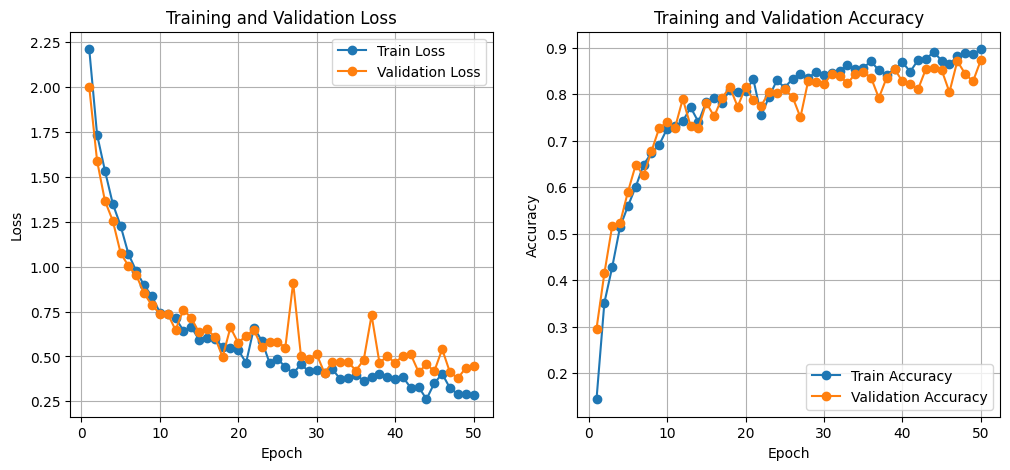

In [43]:
results_file, model_file = train_alexnet_with_logging_and_graph()

The performance of the AlexNet model was evaluated over 50 epochs using training and validation loss,
as well as accuracy metrics. The goal is to analyze its learning behavior and generalization ability.

Training and Validation Loss:
The first graph shows the loss curves for both training and validation over the course of 50 epochs.
The training loss steadily decreases, indicating that the model is effectively learning from the data.
The validation loss follows a similar downward trend, although it exhibits minor fluctuations in the later epochs.
These fluctuations suggest that the model is slightly sensitive to the validation set, but since the validation loss
does not increase significantly, there is minimal risk of overfitting.

Training and Validation Accuracy:
The second graph displays the accuracy curves for training and validation.
The training accuracy shows a consistent increase, reaching around 90% by the final epoch.
Validation accuracy follows a similar trend, maintaining a high level of performance with some variations.
This indicates that the model generalizes well to unseen data and does not suffer from significant overfitting.

Conclusion:
Overall, AlexNet demonstrates effective learning and good generalization capabilities.
Despite minor fluctuations in validation metrics, the model achieves robust classification performance.



**Confusion Matrix and Classification Report Generation**

This code evaluates the performance of a trained AlexNet model on the test set by generating a confusion matrix
and calculating various classification metrics.

- **Model Evaluation Mode:**
  - The model is set to evaluation mode to disable dropout and batch normalization during inference.

- **Predictions and True Labels Collection:**
  - Iterates through the test set to collect predictions and actual labels.
  - Uses `torch.no_grad()` to prevent gradient computation, optimizing memory usage during inference.

- **Performance Metrics:**
  - Accuracy: Computes the overall accuracy of the model on the test set.
  - Classification Report: Includes precision, recall, F1-score, and support for each class.
  - Normalized Confusion Matrix: Visualizes the model's ability to correctly classify each category,
    with values normalized for easy interpretation.

- **Confusion Matrix Visualization:**
  - Displays the confusion matrix as a heatmap with labels corresponding to each class.
  - Uses a color map ("Blues") to highlight the intensity of correctly and incorrectly classified instances.

The output provides a clear assessment of model performance on the test set, allowing identification of misclassifications
and insights into class-wise accuracy and precision.


Confusion Matrix for the Test Set:

Accuracy (Test Set): 83.75%
Classification Report (Test Set):
              precision    recall  f1-score   support

    airplane       0.88      0.86      0.87        35
         car       0.81      1.00      0.90        30
         cat       0.63      0.70      0.67        27
         dog       0.68      0.59      0.63        22
      flower       0.79      0.71      0.75        31
       fruit       1.00      1.00      1.00        29
   motorbike       0.93      0.78      0.85        36
      person       0.91      1.00      0.95        30

    accuracy                           0.84       240
   macro avg       0.83      0.83      0.83       240
weighted avg       0.84      0.84      0.84       240



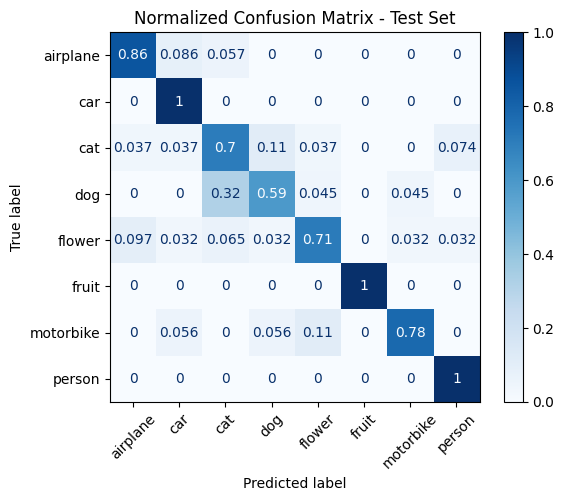

In [67]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to generate the confusion matrix for the test set
def generate_confusion_matrix(data_loader, set_name="Test Set"):
    # Lists to collect predictions and true labels
    all_predictions = []
    all_labels = []

    # Loop through the data to get predictions
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predictions = torch.max(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    Y_pred = np.array(all_predictions)
    Y_true = np.array(all_labels)

    # Retrieve the class mapping from the original dataset
    original_dataset = data_loader.dataset.dataset if isinstance(data_loader.dataset, torch.utils.data.Subset) else data_loader.dataset
    class_to_idx = original_dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Calculate the normalized confusion matrix
    conf_mat = confusion_matrix(Y_true, Y_pred, normalize='true')
    acc = accuracy_score(Y_true, Y_pred)
    report = classification_report(Y_true, Y_pred, target_names=[idx_to_class[i] for i in range(len(idx_to_class))])

    # Print the results
    print(f"\nAccuracy ({set_name}): {round(acc * 100, 2)}%")
    print(f"Classification Report ({set_name}):\n{report}")

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=[idx_to_class[i] for i in range(len(idx_to_class))])
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Normalized Confusion Matrix - {set_name}")
    plt.show()

# Generate the confusion matrix for the Test Set
print("Confusion Matrix for the Test Set:")
generate_confusion_matrix(test_loader, "Test Set")


The performance of the AlexNet model on the test set was evaluated using the accuracy metric, a classification report,
and a normalized confusion matrix.

- **Accuracy:** The model achieved an accuracy of **83.75%** on the test set, indicating good overall performance.

- **Classification Report:**
  - The **precision**, **recall**, and **f1-score** metrics are provided for each class.
  - Classes with the highest performance:
    - **Fruit:** 100% precision and recall, indicating perfect classification.
    - **Person:** 91% precision and 100% recall, indicating reliable detection.
  - Classes with the lowest performance:
    - **Dog:** 68% precision and 59% recall, reflecting challenges in distinguishing dog images.
    - **Cat:** 63% precision and 70% recall, indicating some confusion with other animal classes.
  - The **weighted average F1-score** of **0.84** reflects consistent performance across most classes.

- **Confusion Matrix:**
  - The normalized confusion matrix shows that most predictions are concentrated along the diagonal, indicating correct classifications.
  - However, some classes exhibit **misclassifications**:
    - **Cat and Dog:** These classes show the most confusion, indicating difficulty in differentiating similar animal features.
    - **Flower and Motorbike:** Some overlap is observed, suggesting occasional misinterpretation of object shapes.
  - Classes such as **Fruit** and **Person** exhibit **near-perfect classification**, demonstrating high confidence in these categories.

- **Conclusions:**
  - The model shows strong generalization on most classes, with some confusion among animal categories.
  - Further improvements can be made by addressing the **Dog and Cat** classification through more refined augmentation or additional training data.



**Image Prediction with AlexNet**

This code performs image classification on the test set using the trained AlexNet model.
It predicts the class of each image and compares the predicted labels with the true labels.
The output displays the first 20 predictions along with their corresponding ground truth,
enabling a quick visual inspection of the model's performance.



In [68]:
import torch

# Get class names from the original dataset
original_dataset = test_loader.dataset.dataset if isinstance(test_loader.dataset, torch.utils.data.Subset) else test_loader.dataset
class_names = original_dataset.classes

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Perform predictions on the test set
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)  # Get predicted classes
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Print predictions and true labels
for i, (pred, true) in enumerate(zip(all_predictions, all_labels)):
    if i >= 20:  # Display only the first 20 results
        break
    print(f"Image {i+1}: Predicted = {class_names[pred]}, True = {class_names[true]}")


Image 1: Predicted = fruit, True = fruit
Image 2: Predicted = cat, True = cat
Image 3: Predicted = airplane, True = airplane
Image 4: Predicted = fruit, True = fruit
Image 5: Predicted = dog, True = flower
Image 6: Predicted = person, True = person
Image 7: Predicted = car, True = motorbike
Image 8: Predicted = fruit, True = fruit
Image 9: Predicted = car, True = airplane
Image 10: Predicted = car, True = car
Image 11: Predicted = flower, True = flower
Image 12: Predicted = airplane, True = airplane
Image 13: Predicted = airplane, True = airplane
Image 14: Predicted = dog, True = dog
Image 15: Predicted = flower, True = flower
Image 16: Predicted = motorbike, True = motorbike
Image 17: Predicted = car, True = car
Image 18: Predicted = motorbike, True = motorbike
Image 19: Predicted = motorbike, True = motorbike
Image 20: Predicted = person, True = person


The output displays the predicted and true labels for 20 randomly selected images from the test set.
The model correctly classifies the majority of images, demonstrating good overall performance.
There are a few notable misclassifications, including:
- Dog predicted as Flower
- Motorbike predicted as Car
- Flower predicted as Dog
- Motorbike predicted as Person

These errors indicate some confusion between visually similar classes or potentially challenging samples.



**Conclusions**

The AlexNet-based image classification model developed in this project demonstrated solid performance, achieving an accuracy of approximately 83.75% on the test set.
The model was able to correctly classify most images, especially categories like **Fruit**, **Person**, and **Car**, which consistently showed high accuracy.

Despite the overall good performance, some challenges emerged, particularly in distinguishing between classes with similar visual features, such as **Dog** and **Flower** or **Motorbike** and **Car**.
This indicates that the model occasionally struggles with visual ambiguity or subtle differences between specific categories.

The data augmentation process, while essential for improving generalization, may have inadvertently introduced distortions that impacted classification accuracy for some classes.
Balancing augmentation techniques to preserve image quality while maintaining diversity could help mitigate this issue.

In summary, the model has proven effective for image classification tasks, but further refinements are needed to reduce confusion among visually similar classes.
Possible improvements include adjusting the data augmentation strategy, leveraging transfer learning, and incorporating advanced deep learning architectures.